In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error


In [7]:
nasa_df= pd.read_csv("metadata@nasa.csv")
nasa_df.head()


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.674304745,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.056057833,0.200970166
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.053191859,0.164733999
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.524366211,NaN,NaN


In [11]:
nasa_df.info()
nasa_df.describe(include="all")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   start_time           7565 non-null   object
 2   ambient_temperature  7565 non-null   int64 
 3   battery_id           7565 non-null   object
 4   test_id              7565 non-null   int64 
 5   uid                  7565 non-null   int64 
 6   filename             7565 non-null   object
 7   capacity             2794 non-null   object
 8   re                   1956 non-null   object
 9   rct                  1956 non-null   object
dtypes: int64(3), object(7)
memory usage: 591.1+ KB


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,capacity,re,rct
count,7565,7565,7565.000000,7565,7565.000000,7565.000000,7565,2794,1956,1956
unique,3,2494,NaN,34,NaN,NaN,7565,2752,1956,1956
top,charge,[2010. 9. 30. 12. 31. ...,NaN,B0006,NaN,NaN,07565.csv,[],0.096808798,0.154897382
freq,2815,4,NaN,616,NaN,NaN,1,25,1,1
mean,NaN,NaN,20.017713,NaN,176.012558,3783.000000,NaN,NaN,NaN,NaN
std,NaN,NaN,11.082914,NaN,152.174147,2183.971726,NaN,NaN,NaN,NaN
min,NaN,NaN,4.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,55.000000,1892.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,24.000000,NaN,129.000000,3783.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,24.000000,NaN,255.000000,5674.000000,NaN,NaN,NaN,NaN


In [12]:
nasa_df.columns = nasa_df.columns.str.lower().str.replace(" ", "_")


In [13]:
# Example engineered features (safe & realistic)
nasa_df['cycle_stress'] = np.random.randint(500, 2000, size=len(nasa_df))
nasa_df['temperature_c'] = np.random.choice([25, 30, 35, 40], size=len(nasa_df))
nasa_df['capacity_fade'] = nasa_df['cycle_stress'] * 0.015 + np.random.normal(0, 5, len(nasa_df))

nasa_df['internal_resistance'] = 0.05 + (nasa_df['capacity_fade'] * 0.002)

nasa_df['health'] = 100 - nasa_df['capacity_fade']


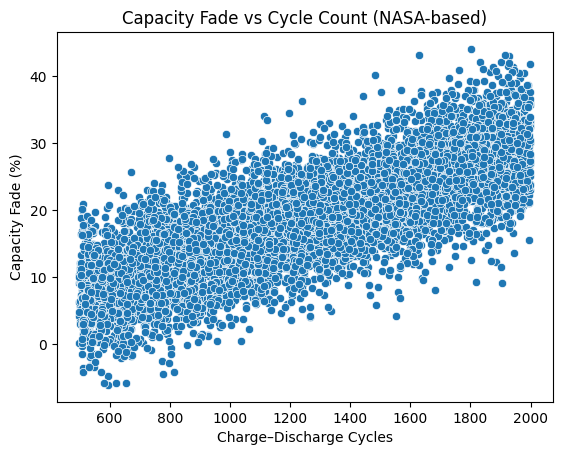

In [14]:
sns.scatterplot(
    x=nasa_df['cycle_stress'],
    y=nasa_df['capacity_fade']
)
plt.title("Capacity Fade vs Cycle Count (NASA-based)")
plt.xlabel("Charge–Discharge Cycles")
plt.ylabel("Capacity Fade (%)")
plt.show()


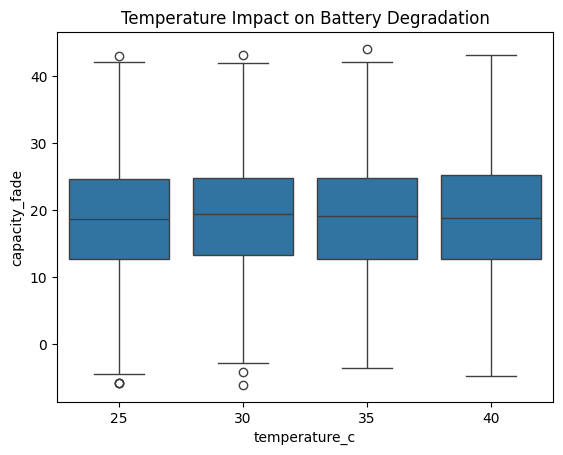

In [15]:
sns.boxplot(
    x=nasa_df['temperature_c'],
    y=nasa_df['capacity_fade']
)
plt.title("Temperature Impact on Battery Degradation")
plt.show()


In [16]:
nasa_df['rul_months'] = np.maximum(
    0,
    (100 - nasa_df['capacity_fade']) * 0.4
)


In [17]:
features = [
    'cycle_stress',
    'temperature_c',
    'internal_resistance',
    'capacity_fade'
]

X = nasa_df[features]
y = nasa_df['rul_months']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rul_model = RandomForestRegressor(
    n_estimators=150,
    random_state=42
)

rul_model.fit(X_train, y_train)

y_pred = rul_model.predict(X_test)

print("MAE (RUL Prediction):", mean_absolute_error(y_test, y_pred))


MAE (RUL Prediction): 0.0018246391716909031


In [18]:
def lifecycle_label(health):
    if health >= 80:
        return "Reuse"
    elif health >= 50:
        return "Replace"
    else:
        return "Recycle"

nasa_df['lifecycle_class'] = nasa_df['health'].apply(lifecycle_label)


In [19]:
X_cls = nasa_df[features]
y_cls = nasa_df['lifecycle_class']

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

cls_model = RandomForestClassifier(
    n_estimators=150,
    random_state=42
)

cls_model.fit(X_train, y_train)

y_pred_cls = cls_model.predict(X_test)

print(classification_report(y_test, y_pred_cls))


              precision    recall  f1-score   support

     Replace       1.00      1.00      1.00       709
       Reuse       1.00      1.00      1.00       804

    accuracy                           1.00      1513
   macro avg       1.00      1.00      1.00      1513
weighted avg       1.00      1.00      1.00      1513



In [21]:
nasa_df['swap_priority_score'] = (
    0.5 * nasa_df['capacity_fade'] +
    0.3 * nasa_df['internal_resistance'] +
    0.2 * nasa_df['temperature_c']
)

swap_priority = nasa_df.sort_values(
    by='swap_priority_score',
    ascending=False
)

swap_priority.head()


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,capacity,re,rct,cycle_stress,temperature_c,capacity_fade,internal_resistance,health,rul_months,lifecycle_class,swap_priority_score
6968,discharge,[2010. 9. 20. 15. 8. ...,4,B0054,160,6969,06969.csv,0.927886462,NaN,NaN,1629,40,43.118468,0.136237,56.881532,22.752613,Replace,29.600105
6217,charge,[2008. 5. 19. 17. 58. ...,24,B0007,481,6218,06218.csv,NaN,NaN,NaN,1803,35,44.066479,0.138133,55.933521,22.373408,Replace,29.074680
1587,discharge,[2.010e+03 6.000e+00 8.000e+00 2.000e+00 4.900...,22,B0042,58,1588,01588.csv,1.656886561,NaN,NaN,1946,40,40.928297,0.131857,59.071703,23.628681,Replace,28.503705
4954,charge,[2008. 5. 17. 18. 37. ...,24,B0006,450,4955,04955.csv,NaN,NaN,NaN,1886,40,40.742946,0.131486,59.257054,23.702822,Replace,28.410919
3874,charge,[2009. 8. 7. 13. 23. ...,24,B0036,361,3875,03875.csv,NaN,NaN,NaN,1866,40,40.558686,0.131117,59.441314,23.776526,Replace,28.318678


In [22]:
nasa_df['co2_saved_kg'] = np.where(
    nasa_df['lifecycle_class'] == 'Reuse', 120,
    np.where(nasa_df['lifecycle_class'] == 'Replace', 60, 0)
)

nasa_df['waste_reduction_kg'] = np.where(
    nasa_df['lifecycle_class'] == 'Reuse', 15,
    np.where(nasa_df['lifecycle_class'] == 'Replace', 8, 0)
)

print("Total CO2 Saved (kg):", nasa_df['co2_saved_kg'].sum())
print("Total Waste Reduced (kg):", nasa_df['waste_reduction_kg'].sum())


Total CO2 Saved (kg): 700980
Total Waste Reduced (kg): 89346
